In [19]:
from datasets import load_dataset
from transformers import ViTImageProcessor
from transformers import ViTForImageClassification
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [2]:
train_ds, test_ds = load_dataset('fashion_mnist', split=['train[:3000]', 'test[:1000]'])
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to C:/Users/gamsi/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'T - shirt / top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [9]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [20]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [23]:
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

tr_transforms = Compose([
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            Normalize(mean=image_mean, std=image_std),])

val_transforms = Compose([
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            Normalize(mean=image_mean, std=image_std),])

def train_transforms(examples):
    examples['pixel_values'] = [tr_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def validate_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_ds.set_transform(train_transforms)
val_ds.set_transform(validate_transforms)
test_ds.set_transform(validate_transforms)

In [24]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [25]:
metric_name = "accuracy"

args = TrainingArguments(
    f"ViT_test_output",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [26]:
trainer.train()

  0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

{'eval_loss': 1.0269498825073242, 'eval_accuracy': 0.7866666666666666, 'eval_runtime': 178.8017, 'eval_samples_per_second': 1.678, 'eval_steps_per_second': 0.419, 'epoch': 1.0}
{'loss': 1.3399, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.85}


  0%|          | 0/75 [00:00<?, ?it/s]

{'eval_loss': 0.7291213870048523, 'eval_accuracy': 0.8233333333333334, 'eval_runtime': 184.0337, 'eval_samples_per_second': 1.63, 'eval_steps_per_second': 0.408, 'epoch': 2.0}


  0%|          | 0/75 [00:00<?, ?it/s]

{'eval_loss': 0.616305947303772, 'eval_accuracy': 0.86, 'eval_runtime': 184.3644, 'eval_samples_per_second': 1.627, 'eval_steps_per_second': 0.407, 'epoch': 3.0}
{'loss': 0.8048, 'learning_rate': 5.185185185185185e-06, 'epoch': 3.7}


  0%|          | 0/75 [00:00<?, ?it/s]

{'eval_loss': 0.5797763466835022, 'eval_accuracy': 0.8533333333333334, 'eval_runtime': 189.3892, 'eval_samples_per_second': 1.584, 'eval_steps_per_second': 0.396, 'epoch': 4.0}


  0%|          | 0/75 [00:00<?, ?it/s]

{'eval_loss': 0.5616165995597839, 'eval_accuracy': 0.8533333333333334, 'eval_runtime': 250.5823, 'eval_samples_per_second': 1.197, 'eval_steps_per_second': 0.299, 'epoch': 5.0}
{'train_runtime': 26269.7527, 'train_samples_per_second': 0.514, 'train_steps_per_second': 0.051, 'train_loss': 0.9795898776584201, 'epoch': 5.0}


TrainOutput(global_step=1350, training_loss=0.9795898776584201, metrics={'train_runtime': 26269.7527, 'train_samples_per_second': 0.514, 'train_steps_per_second': 0.051, 'train_loss': 0.9795898776584201, 'epoch': 5.0})

In [48]:
train_history = trainer.state.log_history
eval_acc = [th['eval_accuracy'] for th in train_history if 'eval_accuracy' in th.keys()]
eval_acc

[0.7866666666666666,
 0.8233333333333334,
 0.86,
 0.8533333333333334,
 0.8533333333333334]

In [ ]:
plt.rc('figure', figsize=(12, 8), dpi=200)
plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('ggplot')

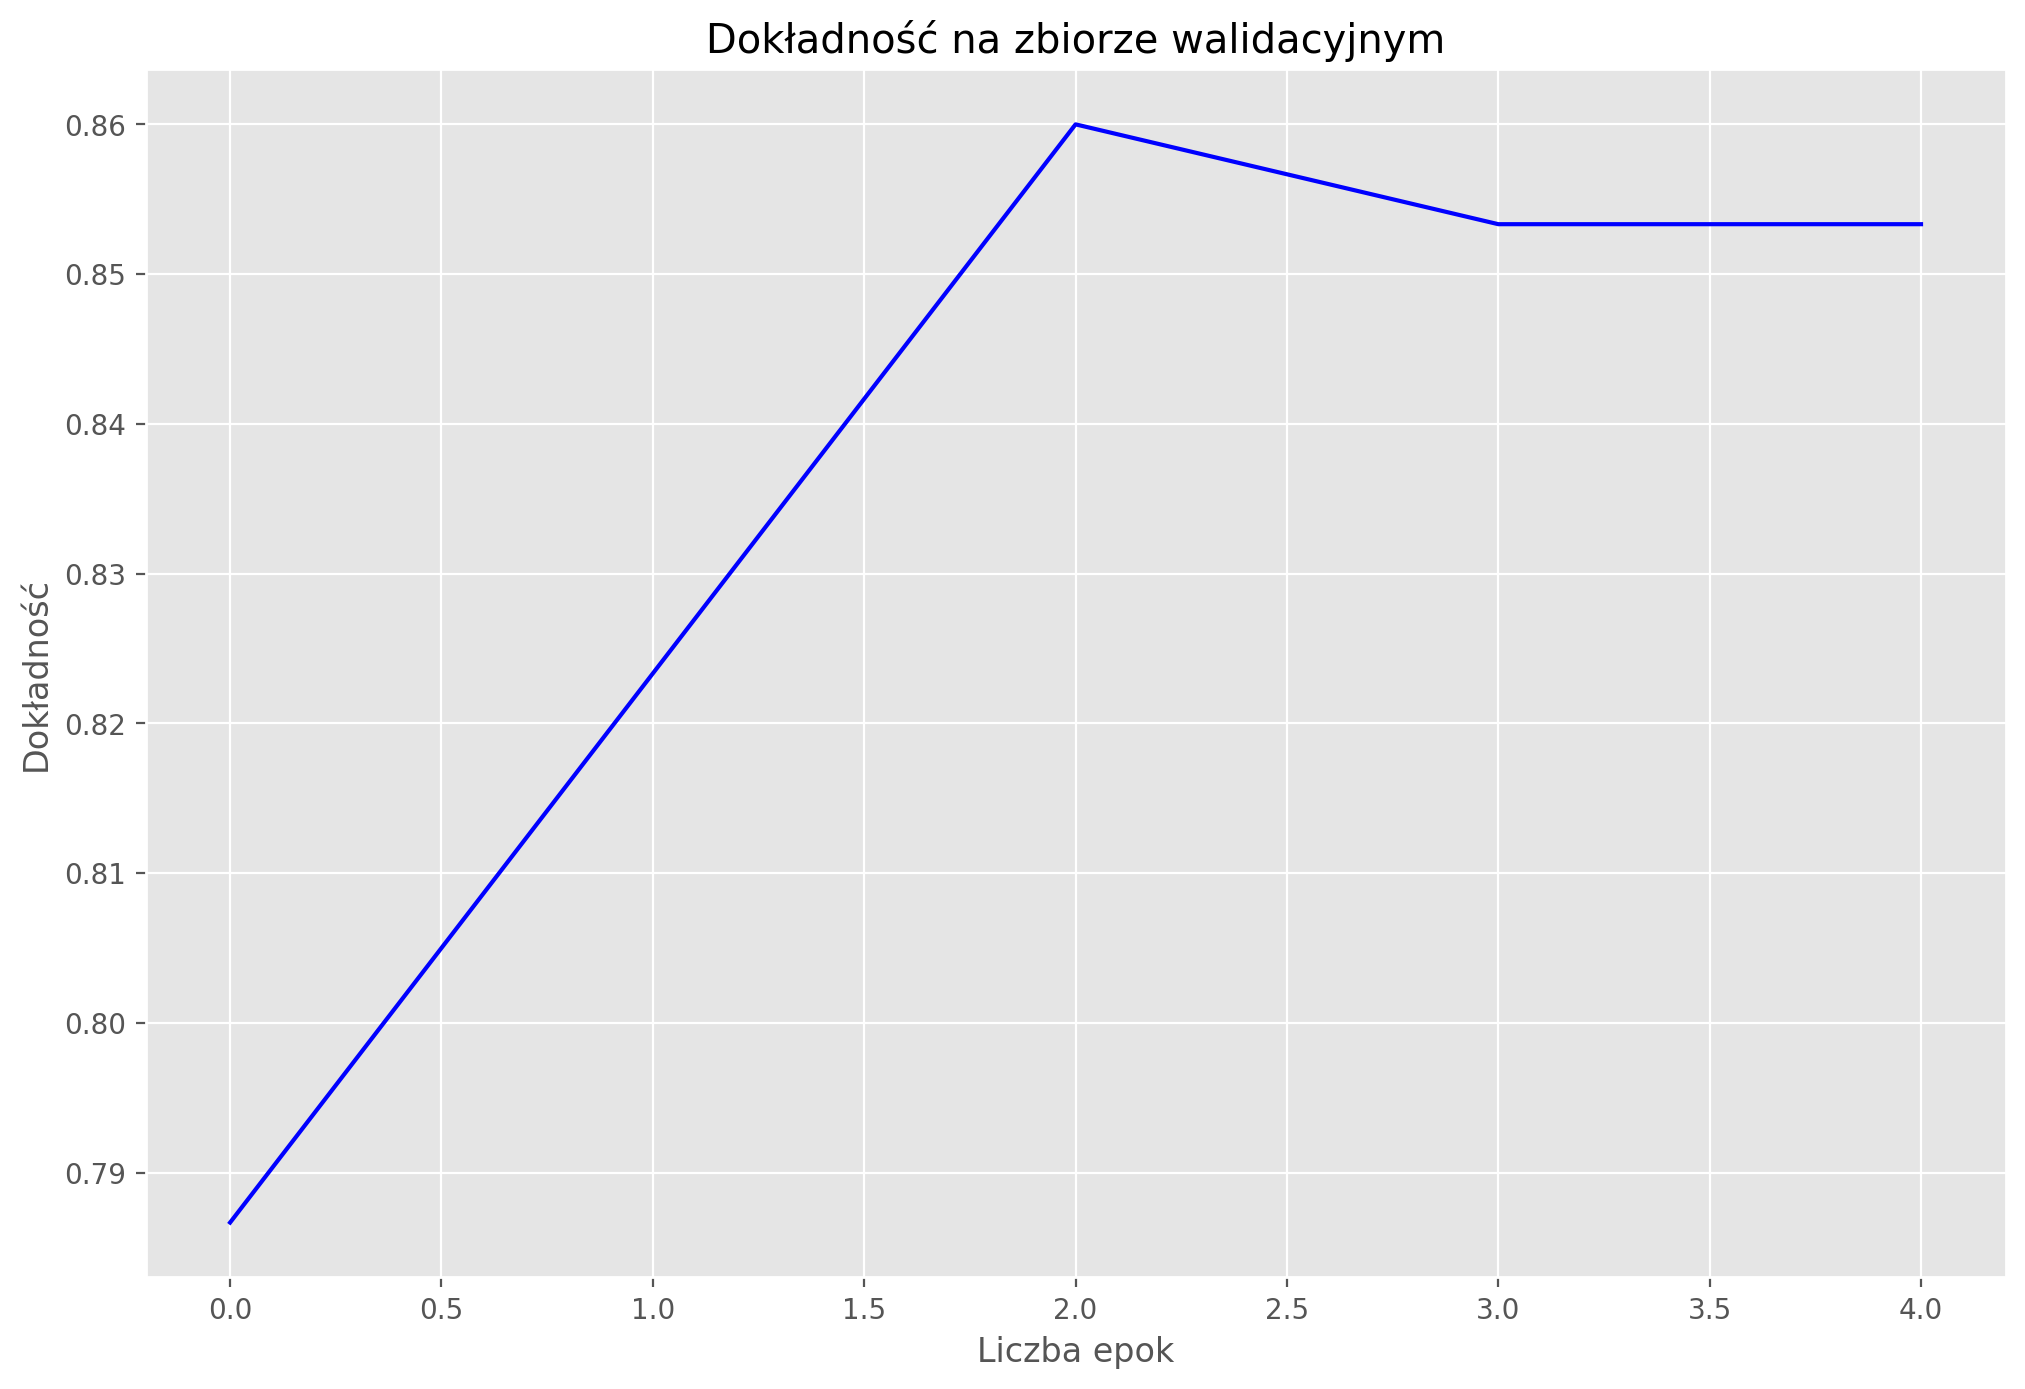

In [51]:
import matplotlib.pyplot as plt
plt.plot(range(5), eval_acc, 'b-')
plt.xlabel('Liczba epok')
plt.ylabel('Dokładność')
plt.title('Dokładność na zbiorze walidacyjnym')
plt.savefig('Dokładność_na_zbiorze_walidacyjnym_vit_fashion.png')
plt.show()

In [27]:
outputs = trainer.predict(test_ds)

  0%|          | 0/250 [00:00<?, ?it/s]

In [28]:
print(outputs.metrics)

{'test_loss': 0.6178917288780212, 'test_accuracy': 0.865, 'test_runtime': 807.4155, 'test_samples_per_second': 1.239, 'test_steps_per_second': 0.31}


<Figure size 2400x1200 with 0 Axes>

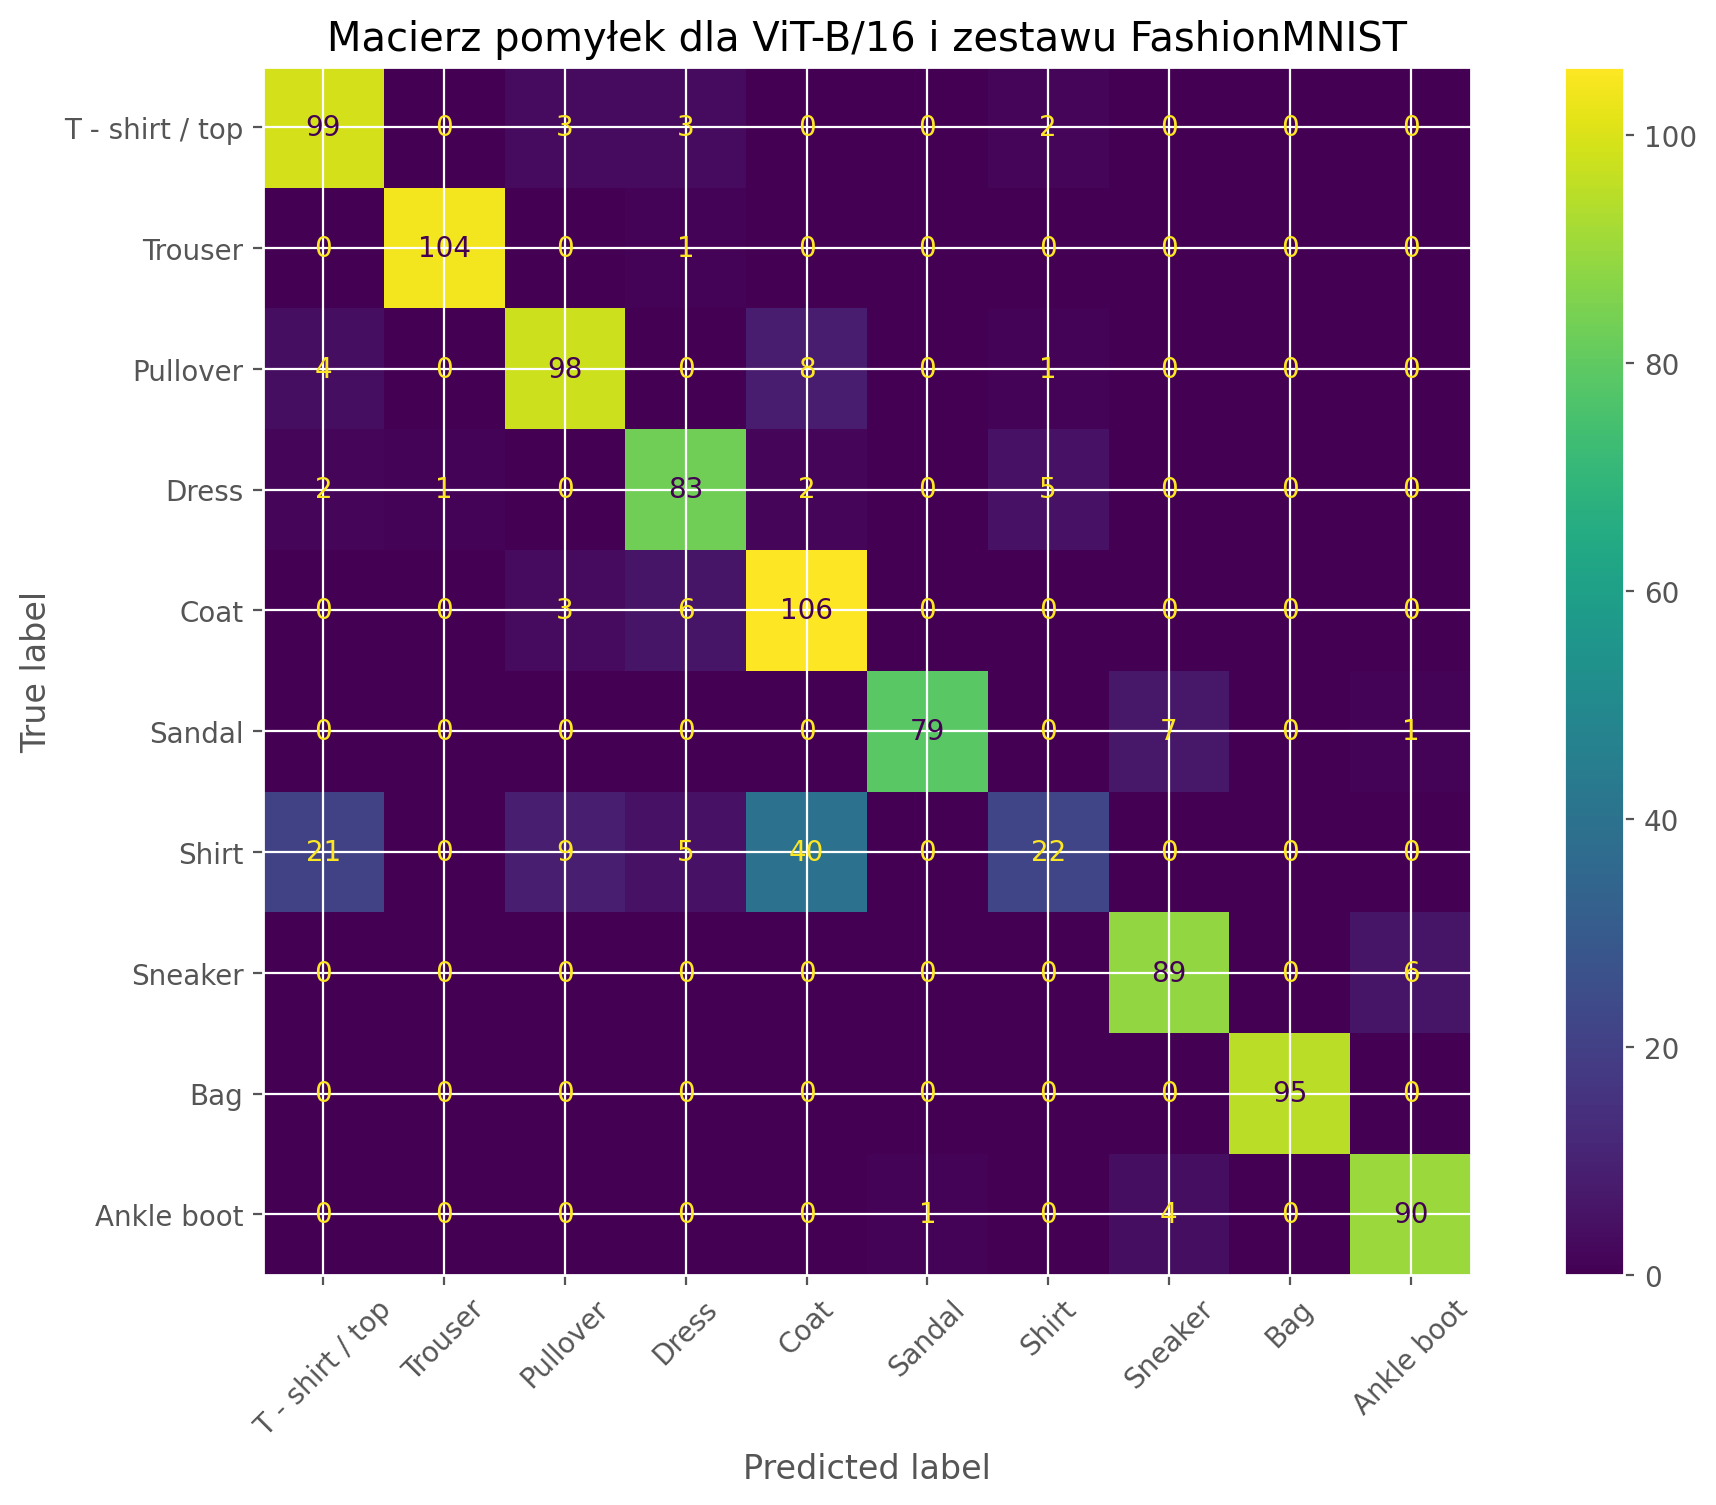

In [32]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
plt.figure(figsize=(12, 6))
labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title("Macierz pomyłek dla ViT-B/16 i zestawu FashionMNIST")
plt.savefig("Macierz_pomyłek_dla_ViT-B16_FASHION.png")